# MRI Recovery

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, concatenate, LeakyReLU, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Activation, Add
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter
from tensorflow.keras.optimizers.schedules import ExponentialDecay


### Load

In [2]:
def load_data(filepath):
    with h5py.File(filepath, 'r') as file:
        trnOrg = np.array(file['trnOrg'])
        trnMask = np.array(file['trnMask'])
        tstOrg = np.array(file['tstOrg'])
        tstMask = np.array(file['tstMask'])
    return trnOrg, trnMask, tstOrg, tstMask

In [3]:
# origing vs blur
def show_images_comparison(org_images, simulated_images, start_index, end_index):
    num_images = end_index - start_index
    plt.figure(figsize=(15, num_images * 2))

    for i in range(num_images):
        index = start_index + i
        # Display the absolute value of the original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.abs(org_images[index]), cmap='gray')
        plt.title(f'Original Image {index}')
        plt.axis('off')

        # Displays the magnitude of the blurred image generated by the simulation
        simulated_abs = np.abs(simulated_images[index, ..., 0] + 1j * simulated_images[index, ..., 1])
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(simulated_abs, cmap='gray')
        plt.title(f'Simulated Blur Image {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

### Prepare Blur Using Guassian

In [4]:
def preprocess_data_gaussian(org, mask=None, sigma=2.5):
    org_mag = np.abs(org)  # Use magnitude for simplicity
    blurred_mag = np.array([gaussian_filter(x, sigma=sigma) for x in org_mag])
    blurred_combined = np.stack((blurred_mag, np.zeros_like(blurred_mag)), axis=-1).astype(np.float32)
    return blurred_combined

In [5]:
# Visiualise origing vs blur
filepath = 'dataset.hdf5'
trnOrg, trnMask, tstOrg, tstMask = load_data(filepath)

trnBlur_gaussian = preprocess_data_gaussian(trnOrg, trnMask)
tstBlur_gaussian = preprocess_data_gaussian(tstOrg, tstMask)

# # Show image comparison within index range
# start_index = 0  
# end_index = 5    
# show_images_comparison(trnOrg, trnBlur_gaussian, start_index, end_index)
# show_images_comparison(tstOrg, tstBlur_gaussian, start_index, end_index)

### Normalization

In [6]:
def normalize_data_real_imag_single(data):
    max_val_real = np.max(np.abs(data[..., 0]))
    max_val_imag = np.max(np.abs(data[..., 1]))
    
    normalized_data = np.copy(data)
    
    if max_val_real != 0:
        normalized_data[..., 0] = data[..., 0] / max_val_real
    else:
        normalized_data[..., 0] = 0  

    if max_val_imag != 0:
        normalized_data[..., 1] = data[..., 1] / max_val_imag
    else:
        normalized_data[..., 1] = 0 
    return normalized_data

def preprocess_target_data(org):
    org_real = np.real(org).astype(np.float32)
    org_imag = np.imag(org).astype(np.float32)
    org_combined = np.stack((org_real, org_imag), axis=-1)
    return org_combined
    
def validate_normalization(*datasets):
    """
    Validates that all given datasets are properly normalized.
    Each dataset in datasets should have real and imaginary parts normalized separately.
    This function checks if all values are within the [-1, 1] range.
    """
    for i, data in enumerate(datasets):
        # Check if any value in the real or imaginary parts is outside the [-1, 1] range
        if np.any(data[..., 0] < -1) or np.any(data[..., 0] > 1) or np.any(data[..., 1] < -1) or np.any(data[..., 1] > 1):
            print(f"Dataset {i} is not properly normalized. Values are outside the [-1, 1] range.")
            return False
    
    print("All datasets are properly normalized within the [-1, 1] range.")
    return True

# origing vs blur
def show_images_comparison_org(org_images, simulated_images, start_index, end_index):
    num_images = end_index - start_index
    plt.figure(figsize=(15, num_images * 2))

    for i in range(num_images):
        index = start_index + i
        # Display the absolute value of the original image
        org_abs = np.abs(org_images[index, ..., 0] + 1j * org_images[index, ..., 1])
        plt.subplot(2, num_images, i + 1)
        plt.imshow(np.abs(org_abs), cmap='gray')
        plt.title(f'Before normalization Image {index}')
        plt.axis('off')

        # Displays the magnitude of the blurred image generated by the simulation
        simulated_abs = np.abs(simulated_images[index, ..., 0] + 1j * simulated_images[index, ..., 1])
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(np.abs(simulated_abs), cmap='gray')
        plt.title(f'After normalization Image {index}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [7]:
# Normalize the datasets separately for real and imaginary components
# Non-blur: trnOrg, trnMask, tstOrg, tstMask
filepath = 'dataset.hdf5'
trnOrg, trnMask, tstOrg, tstMask = load_data(filepath)

# Splite org image to real and imag part
trnOrg_real_imag = preprocess_target_data(trnOrg)
tstOrg_real_imag = preprocess_target_data(tstOrg)

# trnBlur_fourier,tstBlur_fourier
trnOrg_normalized = normalize_data_real_imag_single(trnOrg_real_imag)
tstOrg_normalized = normalize_data_real_imag_single(tstOrg_real_imag)

validate_normalization(trnOrg_normalized,tstOrg_normalized)

# # Show image comparison within index range
# start_index = 0  
# end_index = 5       
# show_images_comparison(trnOrg, trnOrg_normalized, start_index, end_index)
# show_images_comparison(tstOrg, tstOrg_normalized, start_index, end_index)

All datasets are properly normalized within the [-1, 1] range.


True

In [8]:
# trnBlur_gaussian,tstBlur_gaussian
trnBlur_gaussian_normalized = normalize_data_real_imag_single(trnBlur_gaussian)
tstBlur_gaussian_normalized = normalize_data_real_imag_single(tstBlur_gaussian)
validate_normalization(trnBlur_gaussian_normalized, tstBlur_gaussian_normalized)

# # Show image comparison within index range
# start_index = 0  
# end_index = 5       
# show_images_comparison_org(trnBlur_gaussian, trnBlur_gaussian_normalized, start_index, end_index)
# show_images_comparison_org(tstBlur_gaussian, tstBlur_gaussian_normalized, start_index, end_index)

All datasets are properly normalized within the [-1, 1] range.


True

### Build Model

In [9]:
# Custom loss function to handle the real and imaginary parts of complex numbers
def complex_mse_loss(y_true, y_pred):
    real_diff = y_true[..., 0] - y_pred[..., 0]
    imag_diff = y_true[..., 1] - y_pred[..., 1]
    return K.mean(K.square(real_diff) + K.square(imag_diff), axis=-1)
    
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = Activation("relu")(x)
    return x

def unet_model_advanced(input_shape):
    inputs = Input(input_shape)

    # Downsample
    c1 = conv_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    # Bottleneck
    c3 = conv_block(p2, 256)

    # Upsample
    u1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(c3)
    u1 = concatenate([u1, c2])
    u1 = Dropout(0.1)(u1)
    c4 = conv_block(u1, 128)

    u2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c4)
    u2 = concatenate([u2, c1])
    u2 = Dropout(0.1)(u2)
    c5 = conv_block(u2, 64)

    # Output layer
    outputs = Conv2D(2, (1, 1), activation="linear")(c5)
    
    # Add a residual connection
    outputs = Add()([inputs, outputs])

    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='mean_squared_error')
    model.compile(optimizer=Adam(learning_rate=0.001), loss=complex_mse_loss)

    return model

def conv_block2(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = BatchNormalization()(x)  # Adding batch normalization
    x = Activation("relu")(x)
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)  # Adding batch normalization
    x = Activation("relu")(x)
    return x

def unet_model_advanced2(input_shape):
    inputs = Input(input_shape)

    # Downsample
    c1 = conv_block2(inputs, 64)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv_block2(p1, 128)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.1)(p2)

    # Bottleneck
    c3 = conv_block2(p2, 256)
    c3 = Dropout(0.2)(c3)  # Increase dropout for the bottleneck

    # Upsample
    u1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(c3)
    u1 = concatenate([u1, c2])
    u1 = Dropout(0.1)(u1)
    c4 = conv_block2(u1, 128)

    u2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c4)
    u2 = concatenate([u2, c1])
    u2 = Dropout(0.1)(u2)
    c5 = conv_block2(u2, 64)

    # Output layer
    outputs = Conv2D(2, (1, 1), activation="linear")(c5)  # 2 channels for real and imaginary parts

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

def conv_block3(input_tensor, num_filters, kernel_size=3, dropout_rate=0.0, batch_norm=True):
    """Function for convolutional block with optional dropout and batch normalization."""
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding="same")(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout_rate > 0:
        x = Dropout(dropout_rate)(x)
    x = Conv2D(num_filters, (kernel_size, kernel_size), padding="same")(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def unet_model_advanced3(input_shape):
    inputs = Input(input_shape)

    # Downsample
    c1 = conv_block3(inputs, 64, dropout_rate=0.1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block3(p1, 128, dropout_rate=0.1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block3(p2, 256, dropout_rate=0.2)

    # Upsample
    u1 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(c3)
    u1 = concatenate([u1, c2])
    c4 = conv_block3(u1, 128, dropout_rate=0.1)

    u2 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(c4)
    u2 = concatenate([u2, c1])
    c5 = conv_block3(u2, 64, dropout_rate=0.1)

    # Output layer
    outputs = Conv2D(2, (1, 1), activation="linear")(c5)
    
    model = Model(inputs=[inputs], outputs=[outputs])

    # Custom complex MSE loss
    def complex_mse_loss(y_true, y_pred):
        real_diff = y_true[..., 0] - y_pred[..., 0]
        imag_diff = y_true[..., 1] - y_pred[..., 1]
        return K.mean(K.square(real_diff) + K.square(imag_diff), axis=-1)

    model.compile(optimizer=Adam(learning_rate=0.001), loss=complex_mse_loss)

    return model

In [10]:
def visualize_predictions_extended(original_images, blurred_images, predicted_images, start_index, end_index):
    """
     Visualize original, blurred, and predicted images.
     parameter:
     - original_images: Complex data set of original images (real and imaginary parts are not separated and need to be converted to complex form).
     - blurred_images: blurred image data set (real and imaginary parts separated), corresponding to the input of the model.
     - predicted_images: Image data set predicted by the model (real and imaginary parts separated).
     - start_index: The starting index of the image to be visualized.
     - end_index: End index of the image to be visualized (exclusive).
    """
    plt.figure(figsize=(20, 15))
    
    total_images = end_index - start_index
    for i, index in enumerate(range(start_index, end_index), 1):
        # The original image
        plt.subplot(3, total_images, i)
        plt.imshow(np.abs(original_images[index]), cmap='gray')
        plt.title(f'Original Image {index}')
        plt.axis('off')
        
        # The blur image
        plt.subplot(3, total_images, i + total_images)
        blurred_complex = blurred_images[index, ..., 0] + 1j * blurred_images[index, ..., 1]
        plt.imshow(np.abs(blurred_complex), cmap='gray')
        plt.title(f'Blurred Image {index}')
        plt.axis('off')
        
        # The predicted image
        plt.subplot(3, total_images, i + 2 * total_images)
        predicted_complex = predicted_images[index, ..., 0] + 1j * predicted_images[index, ..., 1]
        plt.imshow(np.abs(predicted_complex), cmap='gray')
        plt.title(f'Predicted Image {index}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Calculate the average of PSNR and SSIM
def calculate_metrics(predicted, true):
    num_samples = predicted.shape[0]
    psnr_values = []
    ssim_values = []
    
    for i in range(num_samples):
        # Image reassembled into plural form
        pred_complex = predicted[i, ..., 0] + 1j * predicted[i, ..., 1]
        true_complex = true[i, ..., 0] + 1j * true[i, ..., 1]
        
        # Calculate PSNR and SSIM, using the absolute values of the image
        psnr_val = psnr(np.abs(true_complex), np.abs(pred_complex), data_range=np.abs(true_complex).max() - np.abs(true_complex).min())
        ssim_val = ssim(np.abs(true_complex), np.abs(pred_complex), data_range=np.abs(true_complex).max() - np.abs(true_complex).min())
        psnr_values.append(psnr_val)
        ssim_values.append(ssim_val)
    
    # Calculate average
    average_psnr = np.mean(psnr_values)
    average_ssim = np.mean(ssim_values)
    
    return average_psnr, average_ssim

### Training

In [11]:
# print(trnBlur_gaussian_normalized.shape)
# print(trnOrg_normalized.shape)
# model = unet_model_advanced3(trnBlur_gaussian_normalized.shape[1:])
# # hyperparameters
# history = model.fit(trnBlur_gaussian_normalized, trnOrg_normalized, validation_split=0.1, epochs=10, batch_size=32)
# # model.save('u_net1_Guassian_selfDefineLoss.h5')
# # model.save('u_net2_Guassian.h5')
# model.save('u_net3_Guassian.h5')

### Result

6/6 [==============================] - 7s 1s/step
Average PSNR: 17.82705160701385, Average SSIM: 0.5576938590089899


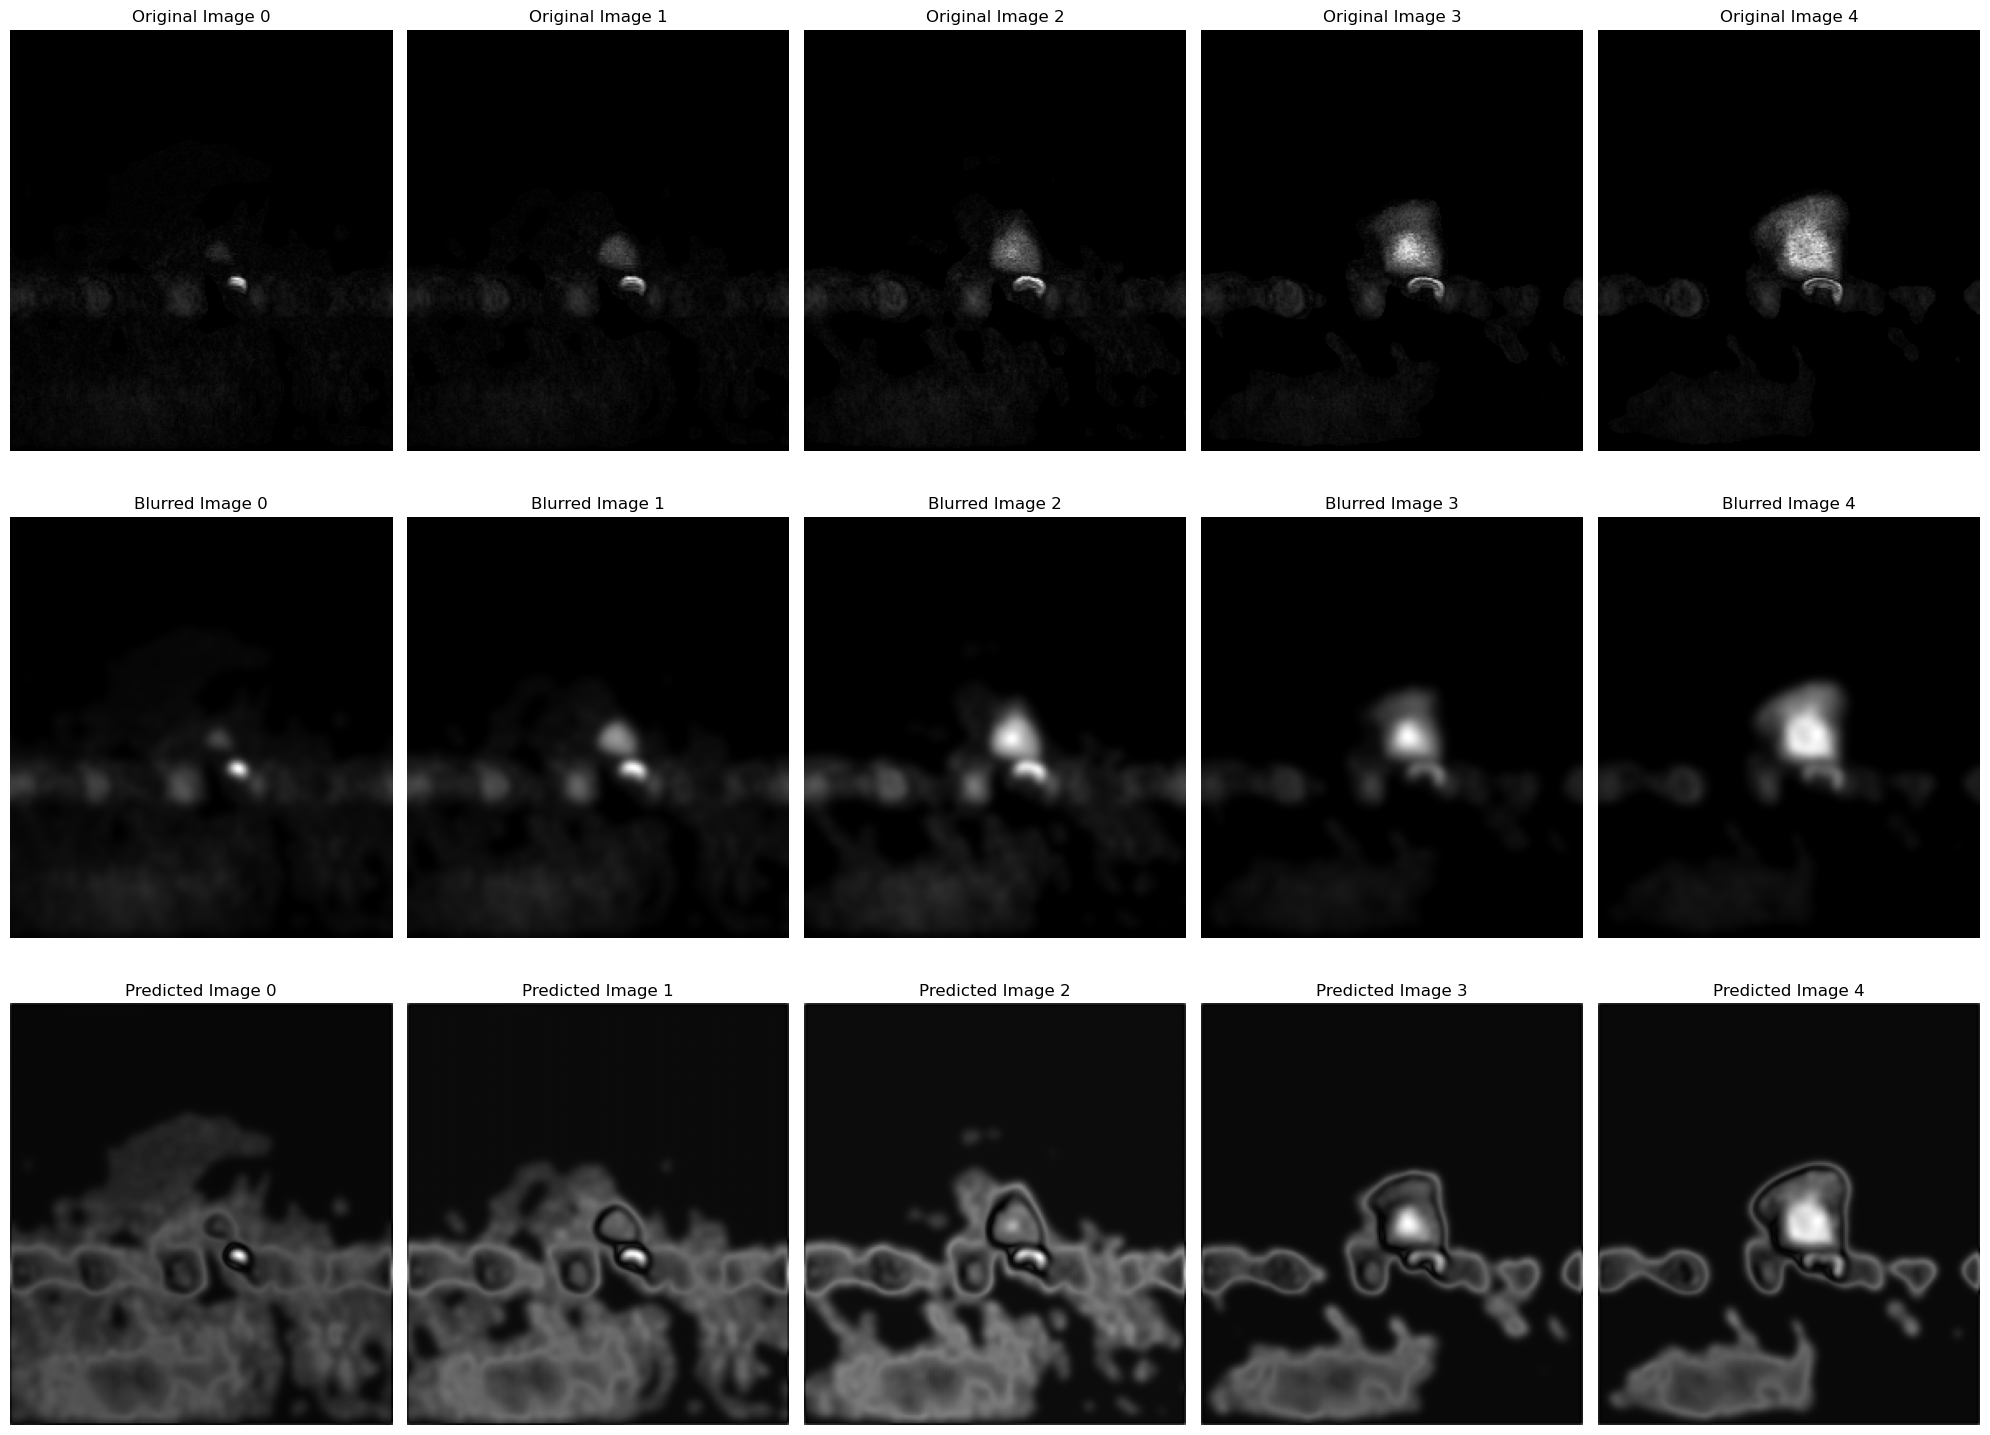

In [12]:
filepath = 'dataset.hdf5'
trnOrg, trnMask, tstOrg, tstMask = load_data(filepath)
# Load the model with the custom_objects parameter to specify custom loss
model = load_model('u_net1_Guassian_selfDefineLoss.h5', custom_objects={'complex_mse_loss': complex_mse_loss})
# model = load_model('u_net_Guassian.h5')

# Use the model to make predictions on the test set
# predicted = model.predict(trnBlur_gaussian_normalized)
predicted = model.predict(tstBlur_gaussian_normalized)

# average_psnr, average_ssim = calculate_metrics(predicted, trnOrg_normalized)
average_psnr, average_ssim = calculate_metrics(predicted, tstOrg_normalized)
print(f"Average PSNR: {average_psnr}, Average SSIM: {average_ssim}")

# visualize_predictions_extended(trnOrg,trnBlur_gaussian_normalized, predicted, 0, 5)
visualize_predictions_extended(tstOrg,tstBlur_gaussian_normalized, predicted, 0, 5)